<a href="https://colab.research.google.com/github/MohammadGhasemiHamed/dreamQuarkTest/blob/main/dreamqaurk2Deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### The Network Description

We Build a deep feed-forward neural network of six Dense layers for the urgent housing classification task. A variable embedding is used for the categorical data and the network architecture apply once the skip connection pattern (employed in ResNets). Finally we build a network using two types of batch normalization, the classical batch normalization and the recent batch Renormalization layer ([Sergey Ioffe, Batch Renormalization: Towards Reducing Minibatch Dependence in Batch-Normalized Models](https://arxiv.org/abs/1702.03275).)


The architecture begins with an embedding layer, a Cat2Vec layer, responsible for converting the categorical variables to numerical values. This embedding layer, converts six categorical variables and concatenates them with the remaining 36 numerical variables. So, the embedding output results in 65 numerical variables which is fed as input for the first Dense layer (Dense 256).


Five dense layers use an ELU activation, a L2 Regularization, the He kernel initializer with a Dropout layer while the sixth layer is a classic softmax layer. These six layers are structured as follows:  
```
Input => {Embedding 65 }=> {Dense 256 =>  Dense 128 => Dense  96 }  => {Dense 64 => Dense 32} =>
                                                                   |                             Concatenate(32,96)=> Softmax 4.
                                                                    ============================>
              

``` 

The network is optimized separately by two iterations where:

 
*   First iteration: the initial three layers and the embedding layer shown below:


```
Input => Embedding 65  => Dense 256 => Dense 128 => Dense 96
```

 are optimized by including them in a five layer network. This five layer network is composed of the initial three layers along with its connected embedding layer and two additional dense layers:

```
{Input => Embedding 65  => Dense 256 => Dense 128  => Dense 96} => Two added {Dense 32=> Softmax 4}.
```  
The task of the two added layers is helping to optimize other layers.  

* Second iteration: the three previous optimized layers, along with their connected embedding layers are frozen and fed as input for three new layers as follows: 

> ```
{Initial Layers output}=> {Dense 64 => Dense 32 => Softmax 4}.
```


>  In the second iteration, the frozen output of the third dense layer (Dense 96) is concatenated to the output of the fifth layer (Dense 32) and the whole is fed as input to the final softmax layer.




> ```
{Frozen 96 outputs}=> Dense 64 => Dense 32 => 
                                               Concatenate(32,96)=> Softmax 4
                         {Frozen 96 outputs}=>
```

* The initial layers, in the first iteration, make use of batch Renormalization layers whereas the deeper Dense 64 and Dense 32 make use of batch normalization layers.

The combination of Renormalization and normalization layers is due to the following observation: 
* We saw that batch Renormalization layers produced better detection rate for the class 3 while batch normalization shown better at improving class 3's precision. 

* Using both type of normalization layers produced better results than competing mono-type normalization architecture.


Please note that the source code of Batch Renormalization layers for Keras is downloaded from https://github.com/titu1994/BatchRenormalization. The file 'batch_renorm.py' should be included for this purpose in the current directory. 


###Prepare Dataset for Deep Neural Net 

In [1]:
##### initialising
import os
import numpy as np
import pandas as pd

os.chdir('/content/drive/My Drive/Python/dreamquark/')
print('current Foler: ',os.getcwd())


use_dummiesFor=['child_to_come','group_type',
                'group_composition_label','housing_situation_label',
                'answer_weekday',
                'long_term_housing_request','requester_type',
                'victim_of_violence_type','victim_of_violence'
                ]

#use_dummiesFor=[]
USE_EMBEDDING=True
remove_list_beforModel=['district']


#remove_list=['town','district']
remove_list=['town','district','group_composition_id','child_situation','housing_situation_id']
#remove_list=[]


convert_dates=True
reduce_housing_situation_label_dummies=False

requests_train=pd.read_csv('requests_train_joindGroups.csv',
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)

requests_test = pd.read_csv('requests_test_joindGroups.csv',
                            sep=',',
                            low_memory=False,
                            error_bad_lines=False)

#######################

requests_train.child_situation=str(requests_train.child_situation)
requests_test.child_situation=str(requests_test.child_situation)

requests_train.district=requests_train.district.apply(str)
requests_test.district=requests_test.district.apply(str)

##############

drop_ind=set(requests_train.district.unique()).difference(set(requests_test.district.unique()))
drop_ind=list(drop_ind)
# training with district 315842
print('removed 1 training obs with district : ',drop_ind)

drop_ind=requests_train.index[requests_train.district.isin(drop_ind)]
requests_train.drop(drop_ind,axis=0,inplace=True)


current Foler:  /content/drive/My Drive/Python/dreamquark
removed 1 training obs with district :  []


In [2]:
#############Utility functions

from  sklearn.preprocessing import LabelEncoder,OneHotEncoder
#################################

seasons = [4, 4, 1, 1, 1, 2, 2, 2, 3, 3, 3, 1]
month_to_season = dict(zip(range(1,13), seasons))

def date_creation(var_df,date_str,var_str):

  var_lundi=var_df[date_str].apply(lambda k:pd.to_datetime(k).weekday()==0).astype(int)
  var_wknd=var_df[date_str].apply(lambda k:(pd.to_datetime(k).weekday() in [5,6]) ).astype(int)
  var_wd=var_df[date_str].apply(lambda k:pd.to_datetime(k).weekday() in [1,2,3,4] ).astype(int)
  var_day=var_df[date_str].apply(lambda k:pd.to_datetime(k).weekday() ).astype(int)


  var_month=var_df[date_str].apply(lambda k:pd.to_datetime(k).month)
  var_season=var_df[date_str].apply(lambda k:month_to_season[pd.to_datetime(k).month])

  var_hour=var_df[date_str].apply(lambda k:pd.to_datetime(k).hour)
  var_is_night=var_df[date_str].apply(lambda k:pd.to_datetime(k).hour>=20 or pd.to_datetime(k).hour<=6 ).astype(int)
 

  var_all= var_df[date_str].apply(lambda k: int('{}{:02d}{:02d}'.format(pd.to_datetime(k).year,pd.to_datetime(k).month,pd.to_datetime(k).day))  )
   
  var_df=var_df.assign( **{
                (var_str+'_islundi'):var_lundi,
                (var_str+'_isweeknd'):var_wknd,
                (var_str+'_mar2vend'):var_wd,
                (var_str+'_weekday'):var_day

#                ,(var_str+'_month'):var_month,
#                (var_str+'_season'):var_season,
#                (var_str+'_hour'):var_hour,
#                (var_str+'_isnight'):var_is_night,
                ,(var_str+'_all'):var_all
  })
  
  return var_df

#############################################################
col_encoders={};
def label_encoder(col,test=False):
  
  #print(col.name)
  if(test):
    encoder=col_encoders[col.name][0]
  else:
    encoder=LabelEncoder()
    if(col_encoders.get(col.name,-1)==-1):
      col_encoders[col.name]=[encoder];
    else:
      col_encoders[col.name].append([encoder]);

    vals=encoder.fit_transform(col)
 
  return vals

#print(encoder.inverse_transform(vals))
######################################################
### encode variables in listOfVars in dummy vars

def encodeVarsInDummy(currentDF,listOfVars,use_dummiesFor,notEnough_carfinalities):
  DUMMY_CAT2VEC={}
  for currentCol in listOfVars:
    #print(currentCol)
    if ((currentCol in use_dummiesFor) and (currentCol not in notEnough_carfinalities)) :
      currentSer=pd.get_dummies(currentDF[currentCol])
      colNames=[ currentCol +'_'+str(name) for name in currentSer.columns];
      #print(colNames)
      currentSer.columns=colNames
      DUMMY_CAT2VEC[currentCol]=list(currentSer.columns)

      currentDF.drop(currentCol,axis=1,inplace=True)
      currentDF[currentSer.columns]=currentSer
    else:
      print(currentCol)
      tmp=label_encoder(currentDF[currentCol])
      #print(np.unique(tmp))
      currentSer=tmp
      currentDF[currentCol+'_converted']=currentSer

  return currentDF,DUMMY_CAT2VEC;



In [3]:
import numpy as np
import pandas as pd
joined_All=pd.read_csv('tmp_final_g3.csv',
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)
print(joined_All.shape)


joined_All.request_creation_date=pd.to_datetime(joined_All.request_creation_date)
joined_All.answer_creation_date=pd.to_datetime(joined_All.answer_creation_date)
joined_All.group_creation_date=pd.to_datetime(joined_All.group_creation_date)
  


(297738, 52)


In [4]:
### seperating training and test set


requests_train=requests_train.sort_values(['answer_creation_date'])
requests_test=requests_test.sort_values(['answer_creation_date'])

final_g3_trains=joined_All[joined_All.request_id.isin(requests_train.request_id)]
final_g3_tests=joined_All[joined_All.request_id.isin(requests_test.request_id)]

final_g3_trains=final_g3_trains.sort_values(['answer_creation_date'])
final_g3_tests=final_g3_tests.sort_values(['answer_creation_date'])


print(final_g3_trains.shape,final_g3_tests.shape)
print(requests_train.shape,requests_test.shape)


(238190, 52) (59548, 52)
(238190, 27) (59548, 27)


In [5]:
requests_train=final_g3_trains
requests_test=final_g3_tests

request_train_sortbyDate=final_g3_trains


In [6]:

#############################################
print ('requests_train column numbers : ',requests_train.columns.shape ,', requests_test column numbers : ',requests_train.columns.shape )
########################################################################



############## creating list for  variables
########################################################################
###  index of not numeric variables
attr_noint_ind=(requests_train.dtypes.values !=  np.dtype('int64')) & (requests_train.dtypes.values !=  np.dtype('float'))
###  index of not date variables
attr_nodate_ind=list(~requests_train.dtypes.isin (  [np.dtype('datetime64[ns]'), np.dtype('<M8[ns]')]   )) 

## index of string variables : not numeric and not date 
attr_str_ind=(attr_noint_ind) & (attr_nodate_ind)

attr_id_ind=list(map(lambda x:str(x) if (str(x).find('_id') ==-1) else '-'  ,requests_train.columns.values))

#list of id varibles (containg word 'id') and type string
attr_id_list=np.array([k for k,s in enumerate(attr_id_ind) if s=='-' and attr_str_ind[k] ])

#2d list of id varibles (containg word 'id') and type string

attr_id_2Dlist=np.array([attr_id_list,
                   requests_test.columns[attr_id_list]
                   ]).transpose()

###########################
## useful list

## string variables not including ids  
attr_string_not_ids=np.array([[k,s] for k,s in enumerate(attr_id_ind) if s!='-' and attr_str_ind[k] and attr_nodate_ind[k] ])
# just an alias, for CAT2VEC
CATEGORICAL_STRINGS=attr_string_not_ids[:,1]


## numeric variables not including ids  
attr_numeric=np.array([[k,s] for k,s in enumerate(attr_id_ind) if s!='-' and ~attr_str_ind[k] and attr_nodate_ind[k]  ])
# just an alias, for CAT2VEC
NUMERICS=list(attr_numeric[:,1])


## list of attr execpt ids : contains numeric and string and date 
attr_useful_withDate=np.array([[k,s] for k,s in enumerate(attr_id_ind) if s!='-'   ])

## not date and not ID: contains numeric and string vars excluding date  and ids
attr_useful=np.array([[k,s] for k,s in enumerate(attr_id_ind) if s!='-' and  (attr_nodate_ind[k] )   ])

MODEL_VARS=list(attr_useful[:,1])

#############################

##### string variables that will be converted to binary should move from one to other

CATEGORICAL_STRINGS=use_dummiesFor
if(USE_EMBEDDING):
  CATEGORICAL_STRINGS=list(set(attr_string_not_ids[:,1]).union(use_dummiesFor))


##############################
notEnough_carfinalities=[]
### remove numeric columns that should be dummy 
NUMERICS=[v for v in NUMERICS if v not in CATEGORICAL_STRINGS]

for colName in CATEGORICAL_STRINGS:
  cardinal=len(requests_train[colName].unique());
  if(cardinal<3):
    notEnough_carfinalities.append(colName)

CATEGORICAL_STRINGS=[v for v in CATEGORICAL_STRINGS if v not in notEnough_carfinalities]
##################

add_to_numeric=[]
add_to_numeric.extend(notEnough_carfinalities)

if(not USE_EMBEDDING):
  add_to_numeric+= list(set(attr_string_not_ids[:,1]).difference(use_dummiesFor))
  
MODEL_VARS=[v for v in MODEL_VARS if v not in add_to_numeric]


add_to_numeric=[v+'_converted' for v in add_to_numeric]
NUMERICS.extend(add_to_numeric)

MODEL_VARS.extend(add_to_numeric)


###################
##verify attribute list correctness
assert(set(attr_id_2Dlist[:,1]).union(set(attr_useful_withDate[:,1])).symmetric_difference(requests_train.columns)==set()) 

### useful attributes are numeric and string, no date, no id
assert(set(MODEL_VARS) ==  set(CATEGORICAL_STRINGS).union( set(NUMERICS) ))



###########################################################################################

if(reduce_housing_situation_label_dummies):

  #'police station', 'detoxification center'
  v=map(lambda k: k if k in ['emergency structure','shelters','street'
  ,'hotel paid by the emergency centre','hotel paid by the regional administration'] else ( 'SayNo' if k  in 
        ['public hospital','parental home', 'psychiatric hospital',
        'accomodation by a third party','police station', 'detoxification center' ] else 'others'), requests_train.housing_situation_label)
  requests_train.housing_situation_label=list(v)


  v=map(lambda k: k if k in ['emergency structure','shelters','street'
  ,'hotel paid by the emergency centre','hotel paid by the regional administration'] else ( 'SayNo' if k  in 
        ['public hospital','parental home', 'psychiatric hospital',
        'accomodation by a third party','police station', 'detoxification center' ] else 'others'), requests_test.housing_situation_label)
  requests_test.housing_situation_label=list(v)
##############################################################





requests_train column numbers :  (52,) , requests_test column numbers :  (52,)


In [7]:
#########################################################
## preparing columns for models
###########################################################################################
DUMMY_CAT2VEC={}
remove_list=[]
### include string and (some numeric that are included in use_dummiesFor)
if(not USE_EMBEDDING or notEnough_carfinalities !=[] ):
  convert_vars=[]
  if(not USE_EMBEDDING):
    convert_vars= list(set(attr_string_not_ids[:,1]).union(set(use_dummiesFor)))

  convert_vars=list(set(convert_vars+notEnough_carfinalities))


  tmp_df=requests_train[convert_vars]
  tmp_df_test=requests_test[convert_vars]

  print ('columns before conversion ',requests_train.columns.shape ,requests_test.columns.shape )

  #### encode all string featutres: those included in 'use_dummiesFor' 
  ####  are converted to dummy and the rest are converted in number

  ### include string and (some numeric that are included in use_dummiesFor)

  tmp_df,DUMMY_CAT2VEC=encodeVarsInDummy(tmp_df,convert_vars,use_dummiesFor,notEnough_carfinalities)
  tmp_df_test,_=encodeVarsInDummy(tmp_df_test,convert_vars,use_dummiesFor,notEnough_carfinalities)

  requests_train[tmp_df.columns]=tmp_df
  requests_test[tmp_df_test.columns]=tmp_df_test

  ### remove string variables
  if(not USE_EMBEDDING):
    requests_train.drop(attr_string_not_ids[:,1],axis=1,inplace=True)
    requests_test.drop(attr_string_not_ids[:,1],axis=1,inplace=True)
    remove_list=list(set(requests_train.columns).intersection(set(CATEGORICAL_STRINGS)))

  for col in notEnough_carfinalities:
    print(' removing column  : ',col)
    requests_train.drop(col,axis=1,inplace=True)
    requests_test.drop(col,axis=1,inplace=True)


  #print (requests_train.columns.shape ,requests_test.columns.shape )
  print ('column numbers',tmp_df.columns.shape ,tmp_df_test.columns.shape )


################
requests_train.long_term_housing_request[requests_train.long_term_housing_request.isna()]='nan'
requests_train.victim_of_violence_type[requests_train.victim_of_violence_type.isna()]='nan'


requests_test.long_term_housing_request[requests_test.long_term_housing_request.isna()]='nan'
requests_test.victim_of_violence_type[requests_test.victim_of_violence_type.isna()]='nan'


#### says about what happens today : the whole day contains the  future, so mut be zero 
requests_train[['nbPresentDay','nbAdmitedDay','nbAdmited1Day','nbAdmited2Day',
                'nbAdmited3Day','nbRejectCard']]= np.zeros((requests_train.shape[0],6))

#np.zeros((requests_train.shape[0],6))

requests_test[['nbPresentDay','nbAdmitedDay','nbAdmited1Day','nbAdmited2Day',
                'nbAdmited3Day','nbRejectCard']]=np.zeros((requests_test.shape[0],6))
###########################################################################################


columns before conversion  (52,) (52,)
child_to_come
grLastAdmitType3
grLastAdmitType1
grLastAdmitTypeNeg
grLastAdmitType2
animal_presence
victim_of_violence
group_type
child_to_come
grLastAdmitType3
grLastAdmitType1
grLastAdmitTypeNeg
grLastAdmitType2
animal_presence


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


victim_of_violence
group_type
 removing column  :  child_to_come
 removing column  :  grLastAdmitType3
 removing column  :  grLastAdmitType1
 removing column  :  grLastAdmitTypeNeg
 removing column  :  animal_presence
 removing column  :  grLastAdmitType2
 removing column  :  victim_of_violence
 removing column  :  group_type
column numbers (16,) (16,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to b

In [8]:



Y=requests_train.granted_number_of_nights
X=requests_train.loc[:,requests_train.columns!='granted_number_of_nights']
X=X.drop(attr_id_2Dlist[:,1],axis=1)
X=X.drop(X.columns[ X.dtypes.values ==   np.dtype('datetime64[ns]')],axis=1)
X=X.drop(columns=remove_list)


Y_test=requests_test.granted_number_of_nights
X_test=requests_test.loc[:,requests_test.columns!='granted_number_of_nights']
X_test=X_test.drop(attr_id_2Dlist[:,1],axis=1)
X_test=X_test.drop(X_test.columns[ X_test.dtypes.values ==   np.dtype('datetime64[ns]')],axis=1)
X_test=X_test.drop(columns=remove_list)

print ('X column numbers : ',X.columns.shape ,', X_test column numbers : ',X_test.columns.shape )

print('number of na :',np.sum(X_test.apply(lambda k :pd.isna(k),axis=0).values)        )

#X_test.fillna(0,inplace=True)



###################
##  check final number of variables

###################
##  check final number of variables
if(not USE_EMBEDDING):
  counter_var=[]
  for i,vars in DUMMY_CAT2VEC.items():
    counter_var.extend(vars);

  numeric_list=list(NUMERICS)
  numeric_list.remove('granted_number_of_nights')
  ### verify X contains only dummy columns extended with numeric ones 
  assert(set(numeric_list+counter_var)==set(X.columns) )

###########
assert(X.columns.shape==X_test.columns.shape)

print('dict of dummy variables for CAT2VEC',DUMMY_CAT2VEC)


X column numbers :  (43,) , X_test column numbers :  (43,)
number of na : 0
dict of dummy variables for CAT2VEC {}


In [9]:

########################################################################
##### finding proprtion of each class
train_props=requests_train.granted_number_of_nights.value_counts(normalize=True).values
test_props=requests_test.granted_number_of_nights.value_counts(normalize=True).values

best_vec=train_props*[1,10,100,1000]
best_vec=best_vec/np.sum(best_vec)
print(best_vec)


[0.01606642 0.11266154 0.51476737 0.35650467]


In [10]:

######### index of observations in training and test sets
#### to be used for debugging or special models including a subset of classes 
from itertools import compress
xind0=np.array(list(compress(range(len(Y)),(Y==0))))
xind1=np.array(list(compress(range(len(Y)),(Y==1))))
xind2=np.array(list(compress(range(len(Y)),(Y==2))))
xind3=np.array(list(compress(range(len(Y)),(Y==3))))

xind01=np.hstack((xind0,xind1))
xind23=np.hstack((xind2,xind3))
xind012=np.hstack((xind0,xind1,xind2))
xind013=np.hstack((xind0,xind1,xind3))
xind023=np.hstack((xind0,xind2,xind3))
xind123=np.hstack((xind1,xind2,xind3))

xIndsDic={0:xind0,1:xind1,2:xind2,3:xind3}

#########################

t_ind0=np.array(list(compress(range(len(Y_test)),(Y_test==0))))
t_ind1=np.array(list(compress(range(len(Y_test)),(Y_test==1))))
t_ind2=np.array(list(compress(range(len(Y_test)),(Y_test==2))))
t_ind3=np.array(list(compress(range(len(Y_test)),(Y_test==3))))

t_ind01=np.hstack((t_ind0,t_ind1))
t_ind23=np.hstack((t_ind2,t_ind3))
t_ind012=np.hstack((t_ind0,t_ind1,t_ind2))
t_ind013=np.hstack((t_ind0,t_ind1,t_ind3))
t_ind023=np.hstack((t_ind0,t_ind2,t_ind3))
t_ind123=np.hstack((t_ind1,t_ind2,t_ind3))


tIndsDic={0:t_ind0,1:t_ind1,2:t_ind2,3:t_ind3}



### 


In [11]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Activation,ELU,BatchNormalization
from tensorflow.keras.layers import Dropout,Dense,Input,Conv1D
from keras.layers import  Reshape,Lambda
from keras.layers import Concatenate, Dropout,Flatten
from keras.layers.embeddings import Embedding
from keras.models import Model,Sequential
from keras.optimizers import RMSprop
from keras.regularizers import l2, l1




import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics, linear_model
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from matplotlib import pyplot as plt




In [12]:
#!pip install --upgrade tensorflow

In [13]:
#X.drop(index=requests_train.index[(requests_train.answer_all < 20190101) & (requests_train.granted_number_of_nights >0) ],inplace=True)
#Y.drop(index=requests_train.index[(requests_train.answer_all < 20190101) & (requests_train.granted_number_of_nights >0) ],inplace=True)

#X.index[(requests_train.answer_all < 20190101) & (requests_train.granted_number_of_nights >0) ]


In [14]:

from sklearn.model_selection import train_test_split

train_data_whole=X.copy()
test_data=X_test.copy()


train_labels_whole=Y.copy()
test_labels=Y_test.copy()


train_data, val_data, train_labels, val_labels = train_test_split(  train_data_whole, train_labels_whole, test_size=0.2, random_state=42)




In [15]:
from sklearn.preprocessing import StandardScaler
NUMERICS_X=NUMERICS.copy()
#NUMERICS_X.remove('district')
NUMERICS_X.remove('answer_all')
NUMERICS_X.remove('granted_number_of_nights')
NUMERICS_X.sort();
train_data.drop(columns=['answer_all'],inplace=True);
train_data_whole.drop(columns=['answer_all'],inplace=True);

val_data.drop(columns=['answer_all'],inplace=True);
test_data.drop(columns=['answer_all'],inplace=True);



/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
scaler = StandardScaler()
scaled_numerics = scaler.fit_transform(train_data_whole[NUMERICS_X])
train_data_whole[NUMERICS_X]=scaled_numerics

scaled_numerics = scaler.fit_transform(train_data[NUMERICS_X])
train_data[NUMERICS_X]=scaled_numerics


scaled_numerics = scaler.transform(val_data[NUMERICS_X])
val_data[NUMERICS_X]=scaled_numerics

scaled_numerics = scaler.transform(test_data[NUMERICS_X])
test_data[NUMERICS_X]=scaled_numerics


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [17]:

#converting data to list format to match the network structure
def preproc(X_train, X_val, X_test):

    input_list_train = []
    input_list_val = []
    input_list_test = []
    
    #the cols to be embedded: rescaling to range [0, # values)
    for c in np.sort(CATEGORICAL_STRINGS):
        #print(c)
        raw_vals = X_train[c].unique()
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i  
            
        #print(val_map)     
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
     
    #the rest of the columns
    other_cols = [c for c in np.sort(X_train.columns) if (not c in CATEGORICAL_STRINGS)]
    input_list_train.append(X_train[other_cols].values)
    input_list_val.append(X_val[other_cols].values)
    input_list_test.append(X_test[other_cols].values)
    
    return input_list_train, input_list_val, input_list_test



In [18]:
X_train_list,X_val_list,X_test_list = preproc(train_data, val_data, test_data)
X_train_list_whole,_,_ = preproc(train_data_whole, val_data, test_data)


###Load & Test the pre-buillt Network

In [56]:
#model = tf.keras.models.load_model('model_cat2vec_densev2_renorm_second.h')
model = tf.keras.models.load_model('model_final.h')



/content/drive/My Drive/Python/dreamquark/batch_renorm.py:97: UserWarning: This implementation of BatchRenormalization is inconsistent with the original paper and therefore results may not be similar ! For discussion on the inconsistency of this implementation, refer here : https://github.com/keras-team/keras-contrib/issues/17
  warnings.warn('This implementation of BatchRenormalization is inconsistent with the '


Look at detection


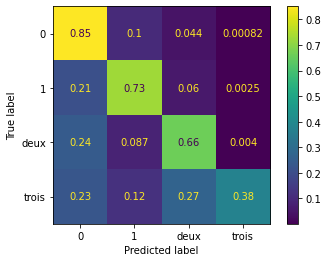

Look at precision


<Figure size 432x288 with 0 Axes>

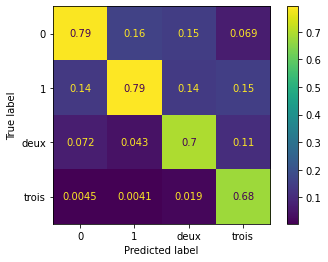




---------- Results -----------------
Posterior competition risk  : 0.3507174620220246 

Prior competition risk  : 1.0239905323872114

-------------- log_loss ---- 
 
Posterior cross entropy  : 0.5381071906824068 

Prior cross entropy  : 1.0534855783636963

----------Accuracy -----------------
 Posterior accuracy   : 0.7753409014576476
 Prior accuracy   : 0.4903775105797004


In [57]:
from sklearn.metrics import plot_confusion_matrix,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 


Y_h=model.predict(X_val_list)
Y=val_labels


Y_h_test=model.predict(X_test_list)
Y_test=test_labels


#X_test_list
print('Look at detection')
t_pred = np.argmax(Y_h_test,axis=1)
#t_pred = np.argmax(Y_h,axis=1)



display_labels=['0','1','deux','trois'];
cm=confusion_matrix(Y_test,t_pred,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)
disp = disp.plot()


plt.show()


print('Look at precision')
plt.figure()

display_labels=['0','1','deux','trois'];
cm=confusion_matrix(Y_test,t_pred,normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)
disp = disp.plot()


plt.show()


print('\n\n\n---------- Results -----------------')

###########################################


from itertools import compress
from sklearn import tree
from  sklearn.metrics import log_loss
from sklearn.metrics import *

def competition_scorer(y_true, y_pred):
    return log_loss(y_true, y_pred, sample_weight=10**y_true,labels=[0,1,2,3])
    #return log_loss(y_true, y_pred,labels=[0,1,2,3])


t=Y_h_test.copy()
Gt=Y_test.copy()

#t=Y_h.copy()
#Gt=Y.copy()

t_pred = np.argmax(t,axis=1)

random_preds=np.random.uniform(low=0.3,high=0.5, size=(len(Gt), 4))


### mode of each distribution
random_preds[:,:]=train_props

#t=t*train_props
t[:,:]=train_props

t[:, [0,1,2,3]]=Y_h_test[:,[0,1,2,3]]
#t[:, [0,1,2,3]]=Y_h[:,[0,1,2,3]]


t=t.astype(np.float128)

#weight_vec=[1,1,1,1]
### multiply posterior proabability with loss function
weight_vec=[1,10,100,1000]
t_vals=np.apply_along_axis(lambda k:(k*weight_vec)/np.sum(k*weight_vec),1,t)  
t_vals[np.isnan(t_vals)]=1
random_vals=np.apply_along_axis(lambda k:(k*weight_vec)/np.sum(k*weight_vec),1,random_preds)  

t[np.isnan(t)]=0.99

print(f'Posterior competition risk  : {competition_scorer(Gt, t_vals)} \n')

print(f'Prior competition risk  : {competition_scorer(Gt, random_vals)}')

print('\n-------------- log_loss ---- \n ')
print(f'Posterior cross entropy  : {log_loss(Gt, t)} \n')

print(f'Prior cross entropy  : {log_loss(Gt, random_preds)}')



#############################

print('\n----------Accuracy -----------------')

print(f' Posterior accuracy   : {accuracy_score(Gt, np.argmax(t,axis=1))}')

print(f' Prior accuracy   : {accuracy_score(Gt, np.argmax(random_preds,axis=1))}')



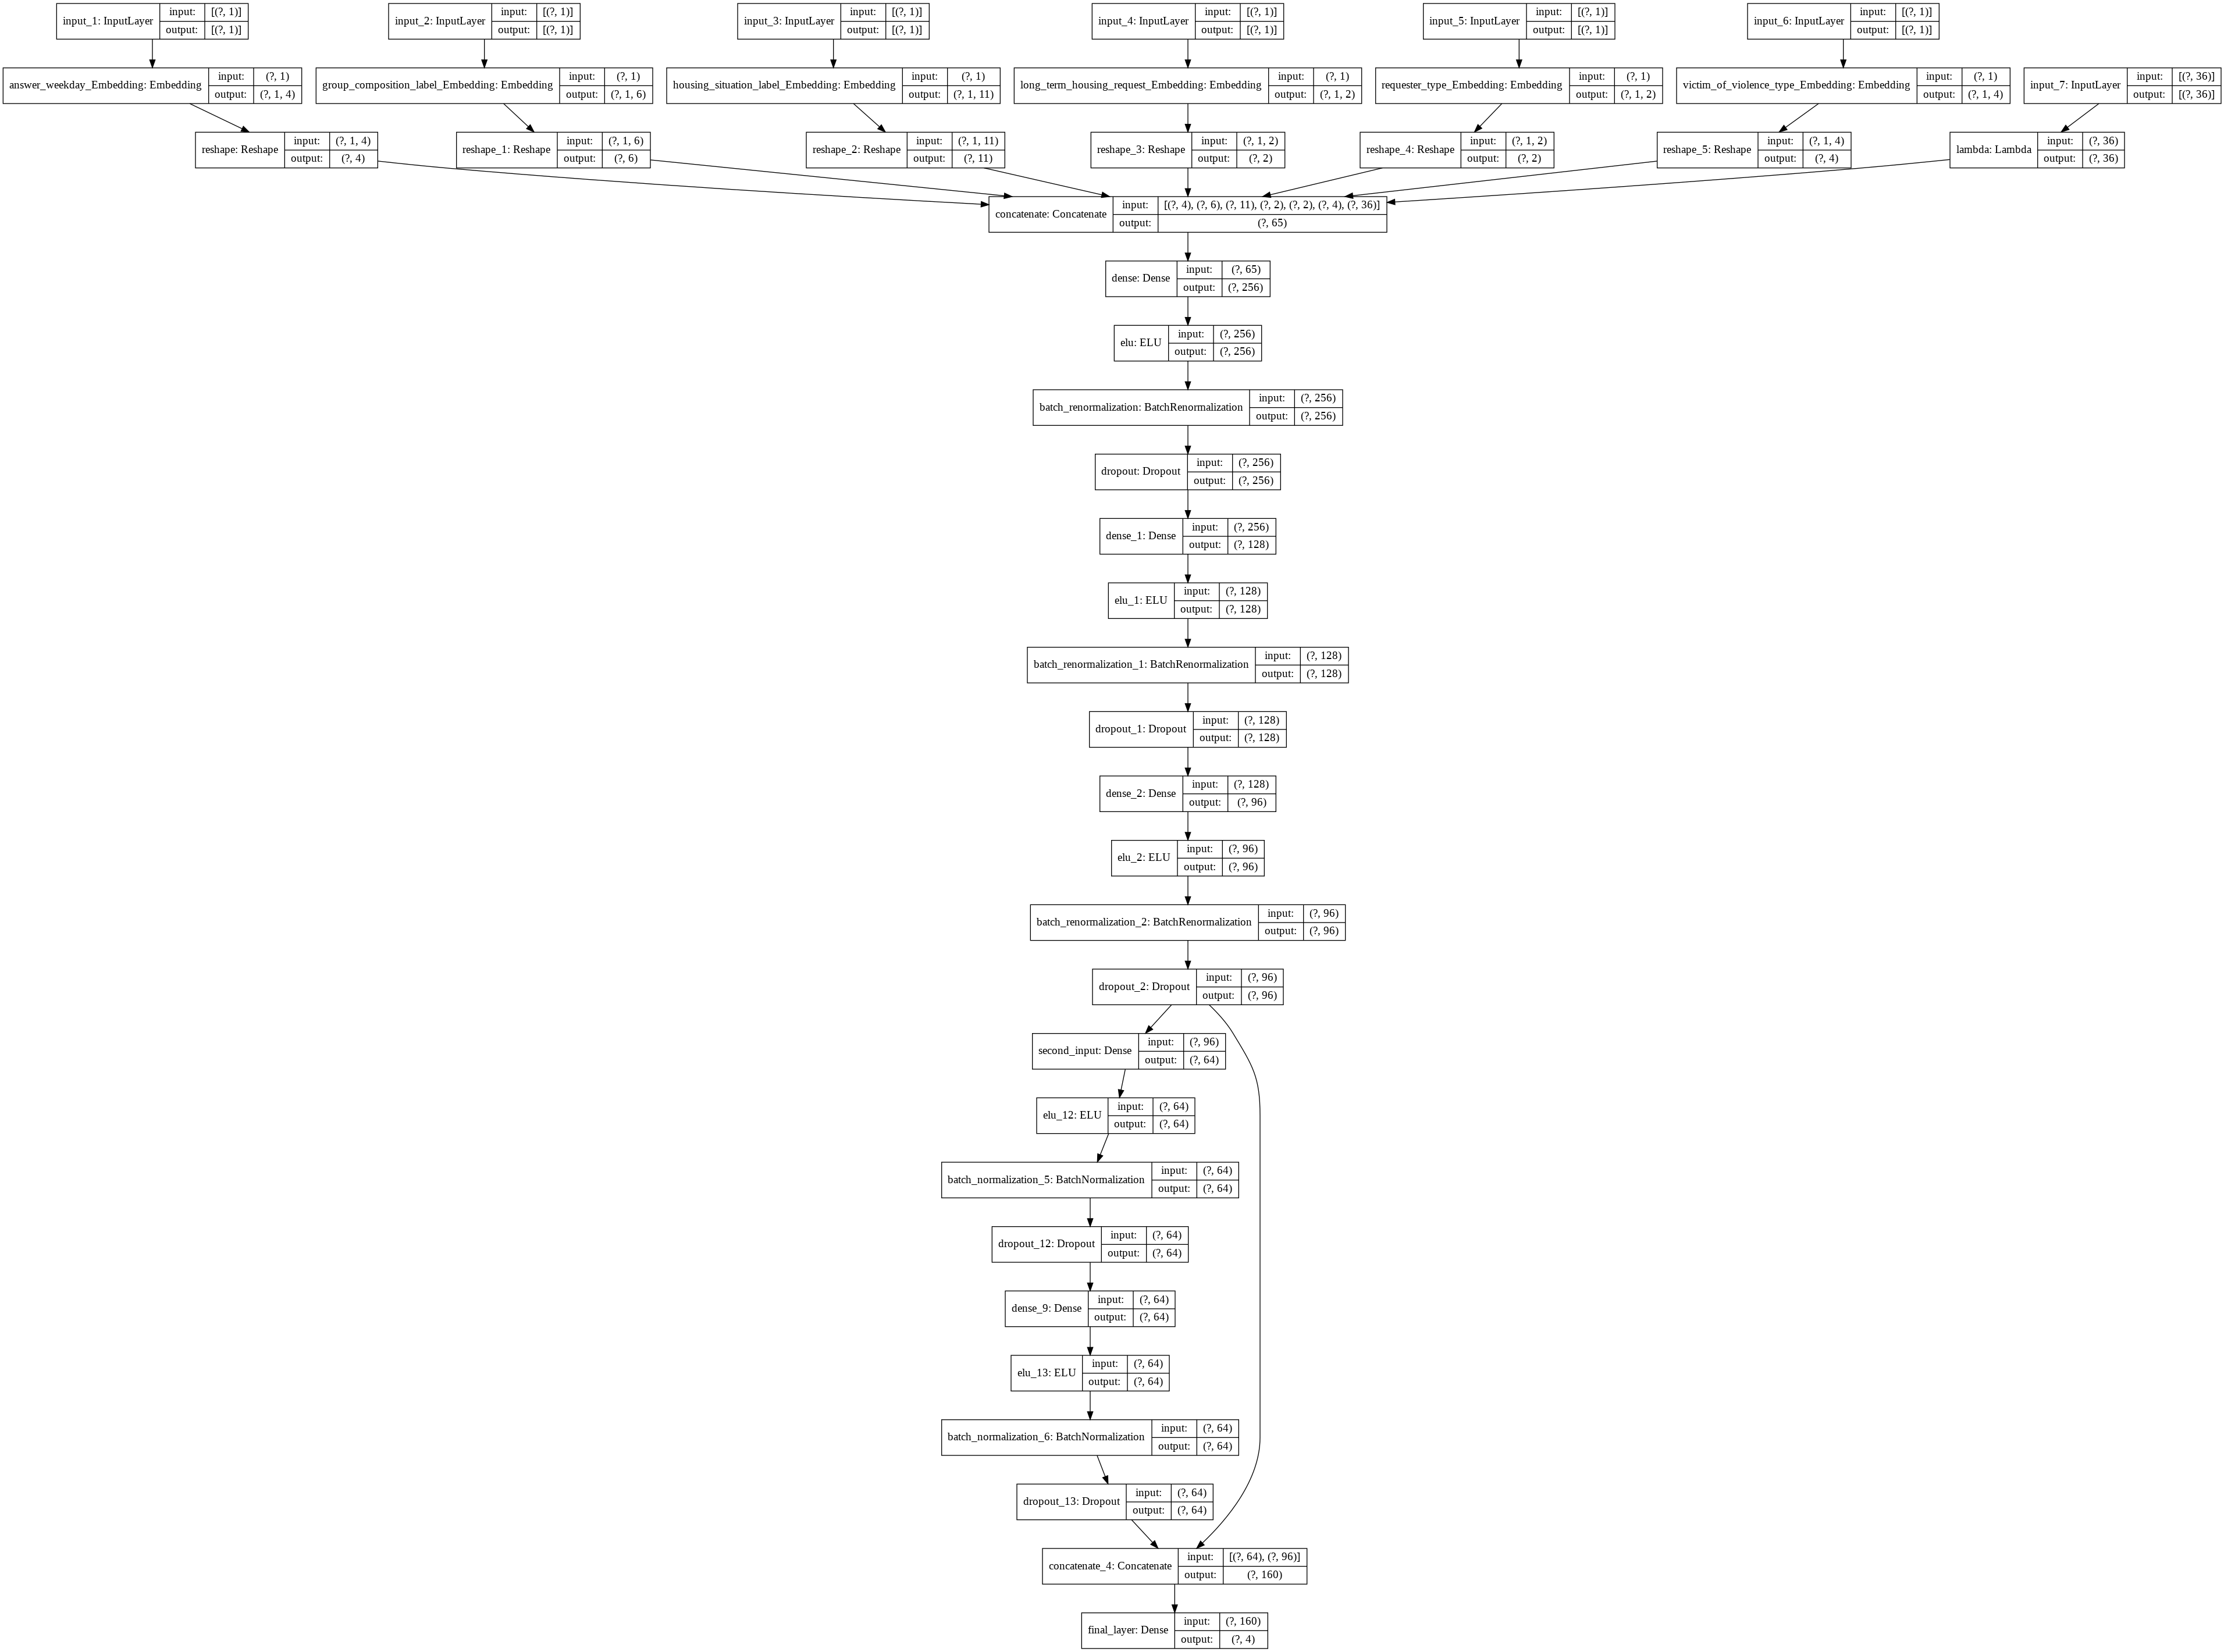

In [59]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')


### Rebuild the Network 

#### Build First Network: iteration 1

In [19]:
from batch_renorm import BatchRenormalization
import importlib



def defModel():
  input_models=[]
  output_embeddings=[]
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

  for categorical_var in np.sort(CATEGORICAL_STRINGS):
      
      #Name of the categorical variable that will be used in the Keras Embedding layer
      cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
    
      # Define the embedding_size
      no_of_unique_cat  = train_data[categorical_var].nunique()
      embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
    
      #One Embedding Layer for each categorical variable
      input_model = Input(shape=(1,))
      output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
      output_model = Reshape(target_shape=(embedding_size,))(output_model)    
    
      #Appending all the categorical inputs
      input_models.append(input_model)
    
      #Appending all the embeddings
      output_embeddings.append(output_model)
    
  #Other non-categorical data columns (numerical). 
  #I define single another network for the other columns and add them to our models list.
  input_numeric = Input(shape=(len(NUMERICS_X),))
  #embedding_numeric = Dense(32)(input_numeric)
  embedding_numeric = Lambda(lambda x: x) (input_numeric) 
  input_models.append(input_numeric)
  output_embeddings.append(embedding_numeric)

  #At the end we concatenate altogther and add other Dense layers
  output = Concatenate()(output_embeddings)
  
  '''

  output=tf.expand_dims(output, axis=-1)

  output = Flatten()(output)
 
  '''
 
  output = Dense(256,kernel_initializer='he_normal',kernel_regularizer=l2(0.002))(output)
  output = ELU(alpha=0.9)(output)      
  output = BatchRenormalization()(output)
  output = Dropout(0.5)(output)


  output = Dense(128,kernel_initializer='he_normal',kernel_regularizer=l2(0.002))(output)
  output = ELU(alpha=0.9)(output)     
  output = BatchRenormalization()(output)
  output = Dropout(0.5)(output)


  output = Dense(96,kernel_initializer='he_normal',kernel_regularizer=l2(0.002))(output)
  output = ELU(alpha=0.9)(output)     
  output = BatchRenormalization()(output)
  output = Dropout(0.5)(output)

  output = Dense(32,kernel_initializer='he_normal',kernel_regularizer=l2(0.002),name='first_gate')(output)
  output = ELU(alpha=0.9)(output)     
  output = BatchRenormalization()(output)
  output = Dropout(0.5)(output)


  output = Dense(4, activation='softmax')(output)

  model = Model(inputs=input_models, outputs=output)
  model.compile(loss='SparseCategoricalCrossentropy', optimizer='Adam',metrics=['accuracy'])
  return model

model=defModel()
model.summary()


/content/drive/My Drive/Python/dreamquark/batch_renorm.py:97: UserWarning: This implementation of BatchRenormalization is inconsistent with the original paper and therefore results may not be similar ! For discussion on the inconsistency of this implementation, refer here : https://github.com/keras-team/keras-contrib/issues/17
  warnings.warn('This implementation of BatchRenormalization is inconsistent with the '


Instructions for updating:
`inputs` is now automatically inferred
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
_____________________

In [20]:
history  =  model.fit(X_train_list,train_labels,validation_data=(X_val_list,val_labels) , epochs =  70 , batch_size = 1024, verbose= 2)


Epoch 1/70
187/187 - 2s - loss: 2.5511 - accuracy: 0.6168 - val_loss: 1.7043 - val_accuracy: 0.7295
Epoch 2/70
187/187 - 2s - loss: 1.4344 - accuracy: 0.7137 - val_loss: 1.0667 - val_accuracy: 0.7410
Epoch 3/70
187/187 - 2s - loss: 0.9819 - accuracy: 0.7274 - val_loss: 0.8017 - val_accuracy: 0.7461
Epoch 4/70
187/187 - 2s - loss: 0.8007 - accuracy: 0.7332 - val_loss: 0.7038 - val_accuracy: 0.7464
Epoch 5/70
187/187 - 2s - loss: 0.7313 - accuracy: 0.7384 - val_loss: 0.6685 - val_accuracy: 0.7487
Epoch 6/70
187/187 - 2s - loss: 0.7076 - accuracy: 0.7402 - val_loss: 0.6539 - val_accuracy: 0.7484
Epoch 7/70
187/187 - 2s - loss: 0.6957 - accuracy: 0.7414 - val_loss: 0.6484 - val_accuracy: 0.7510
Epoch 8/70
187/187 - 2s - loss: 0.6927 - accuracy: 0.7412 - val_loss: 0.6415 - val_accuracy: 0.7512
Epoch 9/70
187/187 - 2s - loss: 0.6857 - accuracy: 0.7423 - val_loss: 0.6410 - val_accuracy: 0.7512
Epoch 10/70
187/187 - 2s - loss: 0.6843 - accuracy: 0.7429 - val_loss: 0.6370 - val_accuracy: 0.7522

In [21]:
model.compile(optimizer=keras.optimizers.Adam(   
    learning_rate=0.0001,    beta_1=0.99,
    beta_2=0.99,epsilon=1e-07),  # Optimizer
# Loss function to minimize
loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'],)
history  =  model.fit(X_train_list,train_labels,validation_data=(X_val_list,val_labels) , epochs =  70 , batch_size = 1024, verbose= 2)


Epoch 1/70
187/187 - 2s - loss: 0.6414 - accuracy: 0.7581 - val_loss: 0.5919 - val_accuracy: 0.7676
Epoch 2/70
187/187 - 2s - loss: 0.6359 - accuracy: 0.7597 - val_loss: 0.5927 - val_accuracy: 0.7684
Epoch 3/70
187/187 - 2s - loss: 0.6323 - accuracy: 0.7589 - val_loss: 0.5873 - val_accuracy: 0.7689
Epoch 4/70
187/187 - 2s - loss: 0.6294 - accuracy: 0.7606 - val_loss: 0.5835 - val_accuracy: 0.7702
Epoch 5/70
187/187 - 2s - loss: 0.6274 - accuracy: 0.7600 - val_loss: 0.5814 - val_accuracy: 0.7710
Epoch 6/70
187/187 - 2s - loss: 0.6267 - accuracy: 0.7604 - val_loss: 0.5814 - val_accuracy: 0.7700
Epoch 7/70
187/187 - 2s - loss: 0.6234 - accuracy: 0.7615 - val_loss: 0.5797 - val_accuracy: 0.7711
Epoch 8/70
187/187 - 2s - loss: 0.6226 - accuracy: 0.7608 - val_loss: 0.5769 - val_accuracy: 0.7709
Epoch 9/70
187/187 - 2s - loss: 0.6212 - accuracy: 0.7617 - val_loss: 0.5776 - val_accuracy: 0.7709
Epoch 10/70
187/187 - 2s - loss: 0.6198 - accuracy: 0.7619 - val_loss: 0.5767 - val_accuracy: 0.7712

In [22]:
opt=keras.optimizers.Adam(     learning_rate=0.00001,    beta_1=0.99,
    beta_2=0.99,epsilon=1e-07)
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
history  =  model.fit(X_train_list,train_labels,validation_data=(X_val_list,val_labels) 
, epochs =  100 , batch_size = 2048, verbose= 2)


Epoch 1/100
94/94 - 2s - loss: 0.6091 - accuracy: 0.7627 - val_loss: 0.5635 - val_accuracy: 0.7734
Epoch 2/100
94/94 - 1s - loss: 0.6069 - accuracy: 0.7649 - val_loss: 0.5658 - val_accuracy: 0.7732
Epoch 3/100
94/94 - 1s - loss: 0.6052 - accuracy: 0.7645 - val_loss: 0.5619 - val_accuracy: 0.7750
Epoch 4/100
94/94 - 1s - loss: 0.6040 - accuracy: 0.7649 - val_loss: 0.5599 - val_accuracy: 0.7754
Epoch 5/100
94/94 - 1s - loss: 0.6036 - accuracy: 0.7654 - val_loss: 0.5603 - val_accuracy: 0.7754
Epoch 6/100
94/94 - 1s - loss: 0.6046 - accuracy: 0.7653 - val_loss: 0.5609 - val_accuracy: 0.7757
Epoch 7/100
94/94 - 1s - loss: 0.6039 - accuracy: 0.7653 - val_loss: 0.5611 - val_accuracy: 0.7753
Epoch 8/100
94/94 - 1s - loss: 0.6030 - accuracy: 0.7650 - val_loss: 0.5600 - val_accuracy: 0.7760
Epoch 9/100
94/94 - 1s - loss: 0.6022 - accuracy: 0.7665 - val_loss: 0.5596 - val_accuracy: 0.7763
Epoch 10/100
94/94 - 1s - loss: 0.6034 - accuracy: 0.7658 - val_loss: 0.5602 - val_accuracy: 0.7760
Epoch 11/

In [23]:
model.save('model_iteration1.h')
print('Iteration 1 saved succesfully !')


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_iteration1.h/assets
Iteration 1 saved succesfully !


In [24]:
#model.summary()


Look at detection


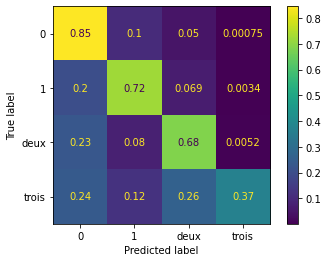

Look at precision


<Figure size 432x288 with 0 Axes>

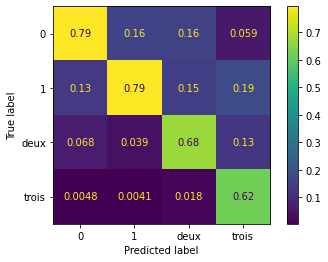




---------- Results -----------------
Posterior competition risk  : 0.37140253170029497 

Prior competition risk  : 1.0239905323872114

-------------- log_loss ---- 
 
Posterior cross entropy  : 0.5432885802453805 

Prior cross entropy  : 1.0534855783636963

----------Accuracy -----------------
 Posterior accuracy   : 0.7737119634580506
 Prior accuracy   : 0.4903775105797004


In [25]:
from sklearn.metrics import plot_confusion_matrix,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 


Y_h=model.predict(X_val_list)
Y=val_labels


Y_h_test=model.predict(X_test_list)
Y_test=test_labels


#X_test_list
print('Look at detection')
t_pred = np.argmax(Y_h_test,axis=1)
#t_pred = np.argmax(Y_h,axis=1)



display_labels=['0','1','deux','trois'];
cm=confusion_matrix(Y_test,t_pred,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)
disp = disp.plot()


plt.show()


print('Look at precision')
plt.figure()

display_labels=['0','1','deux','trois'];
cm=confusion_matrix(Y_test,t_pred,normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)
disp = disp.plot()


plt.show()


print('\n\n\n---------- Results -----------------')

###########################################


from itertools import compress
from sklearn import tree
from  sklearn.metrics import log_loss
from sklearn.metrics import *

def competition_scorer(y_true, y_pred):
    return log_loss(y_true, y_pred, sample_weight=10**y_true,labels=[0,1,2,3])
    #return log_loss(y_true, y_pred,labels=[0,1,2,3])


t=Y_h_test.copy()
Gt=Y_test.copy()

#t=Y_h.copy()
#Gt=Y.copy()

t_pred = np.argmax(t,axis=1)

random_preds=np.random.uniform(low=0.3,high=0.5, size=(len(Gt), 4))


### mode of each distribution
random_preds[:,:]=train_props

#t=t*train_props
t[:,:]=train_props

t[:, [0,1,2,3]]=Y_h_test[:,[0,1,2,3]]
#t[:, [0,1,2,3]]=Y_h[:,[0,1,2,3]]


t=t.astype(np.float128)

#weight_vec=[1,1,1,1]
### multiply posterior proabability with loss function
weight_vec=[1,10,100,1000]
t_vals=np.apply_along_axis(lambda k:(k*weight_vec)/np.sum(k*weight_vec),1,t)  
t_vals[np.isnan(t_vals)]=1
random_vals=np.apply_along_axis(lambda k:(k*weight_vec)/np.sum(k*weight_vec),1,random_preds)  

t[np.isnan(t)]=0.99

print(f'Posterior competition risk  : {competition_scorer(Gt, t_vals)} \n')

print(f'Prior competition risk  : {competition_scorer(Gt, random_vals)}')

print('\n-------------- log_loss ---- \n ')
print(f'Posterior cross entropy  : {log_loss(Gt, t)} \n')

print(f'Prior cross entropy  : {log_loss(Gt, random_preds)}')



#############################

print('\n----------Accuracy -----------------')

print(f' Posterior accuracy   : {accuracy_score(Gt, np.argmax(t,axis=1))}')

print(f' Prior accuracy   : {accuracy_score(Gt, np.argmax(random_preds,axis=1))}')




#### Build Final Network: iteration 2

In [46]:
def defModel2():
  model_frozen = tf.keras.models.load_model('model_iteration1.h')
  out1= model_frozen.get_layer('first_gate')

  print(model_frozen.layers[-6].name)

  for layer in model_frozen.layers:
    layer.trainable=False;

  output=model_frozen.layers[-6].output

  
  output = Dense(64,kernel_initializer='he_normal',kernel_regularizer=l2(0.002),name='second_input')(output)
  output = ELU(alpha=0.9)(output)      
  output = BatchNormalization()(output)
  output = Dropout(0.5)(output)

  output = Dense(64,kernel_initializer='he_normal',kernel_regularizer=l2(0.002))(output)
  output = ELU(alpha=0.9)(output)      
  output = BatchNormalization()(output)
  output = Dropout(0.5)(output)

  output = Concatenate()([output,model_frozen.layers[-6].output])

  final_layer = Dense(4, activation='softmax',name='final_layer')(output)

  new_model = Model(model_frozen.inputs, final_layer)

  return new_model

model=defModel2()

model.compile(loss='SparseCategoricalCrossentropy', optimizer='Adam',metrics=['accuracy'])


/content/drive/My Drive/Python/dreamquark/batch_renorm.py:97: UserWarning: This implementation of BatchRenormalization is inconsistent with the original paper and therefore results may not be similar ! For discussion on the inconsistency of this implementation, refer here : https://github.com/keras-team/keras-contrib/issues/17
  warnings.warn('This implementation of BatchRenormalization is inconsistent with the '


dropout_2


In [47]:
history  =  model.fit(X_train_list,train_labels,validation_data=(X_val_list,val_labels) , epochs =  50 , batch_size = 1024, verbose= 2)


Epoch 1/50
187/187 - 2s - loss: 1.3636 - accuracy: 0.6738 - val_loss: 0.9040 - val_accuracy: 0.7752
Epoch 2/50
187/187 - 1s - loss: 0.8946 - accuracy: 0.7491 - val_loss: 0.7275 - val_accuracy: 0.7759
Epoch 3/50
187/187 - 1s - loss: 0.7345 - accuracy: 0.7586 - val_loss: 0.6427 - val_accuracy: 0.7744
Epoch 4/50
187/187 - 1s - loss: 0.6595 - accuracy: 0.7632 - val_loss: 0.6003 - val_accuracy: 0.7747
Epoch 5/50
187/187 - 1s - loss: 0.6255 - accuracy: 0.7642 - val_loss: 0.5800 - val_accuracy: 0.7750
Epoch 6/50
187/187 - 1s - loss: 0.6098 - accuracy: 0.7662 - val_loss: 0.5700 - val_accuracy: 0.7760
Epoch 7/50
187/187 - 1s - loss: 0.6026 - accuracy: 0.7657 - val_loss: 0.5653 - val_accuracy: 0.7764
Epoch 8/50
187/187 - 1s - loss: 0.5972 - accuracy: 0.7668 - val_loss: 0.5621 - val_accuracy: 0.7766
Epoch 9/50
187/187 - 1s - loss: 0.5952 - accuracy: 0.7671 - val_loss: 0.5614 - val_accuracy: 0.7767
Epoch 10/50
187/187 - 1s - loss: 0.5938 - accuracy: 0.7668 - val_loss: 0.5608 - val_accuracy: 0.7763

In [48]:
opt=keras.optimizers.Adam(     learning_rate=0.0001,    beta_1=0.99,
    beta_2=0.99,epsilon=1e-07)
model.compile(optimizer=opt, # Optimizer
# Loss function to minimize
loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
history  =  model.fit(X_train_list,train_labels,validation_data=(X_val_list,val_labels) , epochs =  50 , batch_size = 2048, verbose= 2)


Epoch 1/50
94/94 - 1s - loss: 0.5873 - accuracy: 0.7674 - val_loss: 0.5568 - val_accuracy: 0.7758
Epoch 2/50
94/94 - 1s - loss: 0.5859 - accuracy: 0.7686 - val_loss: 0.5567 - val_accuracy: 0.7764
Epoch 3/50
94/94 - 1s - loss: 0.5849 - accuracy: 0.7685 - val_loss: 0.5560 - val_accuracy: 0.7766
Epoch 4/50
94/94 - 1s - loss: 0.5855 - accuracy: 0.7675 - val_loss: 0.5562 - val_accuracy: 0.7763
Epoch 5/50
94/94 - 1s - loss: 0.5846 - accuracy: 0.7691 - val_loss: 0.5561 - val_accuracy: 0.7762
Epoch 6/50
94/94 - 1s - loss: 0.5849 - accuracy: 0.7690 - val_loss: 0.5557 - val_accuracy: 0.7766
Epoch 7/50
94/94 - 1s - loss: 0.5852 - accuracy: 0.7689 - val_loss: 0.5559 - val_accuracy: 0.7765
Epoch 8/50
94/94 - 1s - loss: 0.5844 - accuracy: 0.7684 - val_loss: 0.5560 - val_accuracy: 0.7762
Epoch 9/50
94/94 - 1s - loss: 0.5843 - accuracy: 0.7687 - val_loss: 0.5559 - val_accuracy: 0.7763
Epoch 10/50
94/94 - 1s - loss: 0.5849 - accuracy: 0.7687 - val_loss: 0.5556 - val_accuracy: 0.7765
Epoch 11/50
94/94 -

In [49]:
opt=keras.optimizers.Adam(     learning_rate=0.00001,    beta_1=0.99,
    beta_2=0.99,epsilon=1e-07)
model.compile(optimizer=opt, # Optimizer
# Loss function to minimize
loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])
history  =  model.fit(X_train_list,train_labels,validation_data=(X_val_list,val_labels) , epochs =  50 , batch_size = 2048, verbose= 2)


Epoch 1/50
94/94 - 1s - loss: 0.5845 - accuracy: 0.7676 - val_loss: 0.5552 - val_accuracy: 0.7766
Epoch 2/50
94/94 - 1s - loss: 0.5838 - accuracy: 0.7685 - val_loss: 0.5553 - val_accuracy: 0.7762
Epoch 3/50
94/94 - 1s - loss: 0.5835 - accuracy: 0.7690 - val_loss: 0.5552 - val_accuracy: 0.7764
Epoch 4/50
94/94 - 1s - loss: 0.5841 - accuracy: 0.7681 - val_loss: 0.5552 - val_accuracy: 0.7764
Epoch 5/50
94/94 - 1s - loss: 0.5847 - accuracy: 0.7676 - val_loss: 0.5553 - val_accuracy: 0.7764
Epoch 6/50
94/94 - 1s - loss: 0.5844 - accuracy: 0.7676 - val_loss: 0.5553 - val_accuracy: 0.7765
Epoch 7/50
94/94 - 1s - loss: 0.5832 - accuracy: 0.7687 - val_loss: 0.5553 - val_accuracy: 0.7764
Epoch 8/50
94/94 - 1s - loss: 0.5830 - accuracy: 0.7679 - val_loss: 0.5551 - val_accuracy: 0.7766
Epoch 9/50
94/94 - 1s - loss: 0.5842 - accuracy: 0.7687 - val_loss: 0.5553 - val_accuracy: 0.7765
Epoch 10/50
94/94 - 1s - loss: 0.5843 - accuracy: 0.7684 - val_loss: 0.5553 - val_accuracy: 0.7765
Epoch 11/50
94/94 -

In [54]:
model.save('model_final.h')
print('Iteration 2 saved succesfully !')

INFO:tensorflow:Assets written to: model_final.h/assets
Iteration 2 saved succesfully !


### View Results

Look at detection


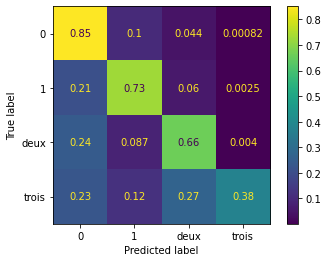

Look at precision


<Figure size 432x288 with 0 Axes>

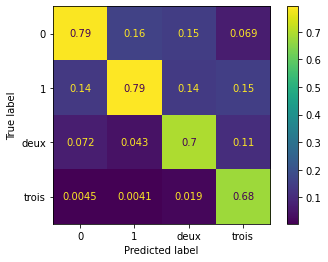




---------- Results -----------------
Posterior competition risk  : 0.3507174620220246 

Prior competition risk  : 1.0239905323872114

-------------- log_loss ---- 
 
Posterior cross entropy  : 0.5381071906824068 

Prior cross entropy  : 1.0534855783636963

----------Accuracy -----------------
 Posterior accuracy   : 0.7753409014576476
 Prior accuracy   : 0.4903775105797004


In [53]:
from sklearn.metrics import plot_confusion_matrix,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 


Y_h=model.predict(X_val_list)
Y=val_labels


Y_h_test=model.predict(X_test_list)
Y_test=test_labels


#X_test_list
print('Look at detection')
t_pred = np.argmax(Y_h_test,axis=1)
#t_pred = np.argmax(Y_h,axis=1)



display_labels=['0','1','deux','trois'];
cm=confusion_matrix(Y_test,t_pred,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)
disp = disp.plot()


plt.show()


print('Look at precision')
plt.figure()

display_labels=['0','1','deux','trois'];
cm=confusion_matrix(Y_test,t_pred,normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)
disp = disp.plot()


plt.show()


print('\n\n\n---------- Results -----------------')

###########################################


from itertools import compress
from sklearn import tree
from  sklearn.metrics import log_loss
from sklearn.metrics import *

def competition_scorer(y_true, y_pred):
    return log_loss(y_true, y_pred, sample_weight=10**y_true,labels=[0,1,2,3])
    #return log_loss(y_true, y_pred,labels=[0,1,2,3])


t=Y_h_test.copy()
Gt=Y_test.copy()

#t=Y_h.copy()
#Gt=Y.copy()

t_pred = np.argmax(t,axis=1)

random_preds=np.random.uniform(low=0.3,high=0.5, size=(len(Gt), 4))


### mode of each distribution
random_preds[:,:]=train_props

#t=t*train_props
t[:,:]=train_props

t[:, [0,1,2,3]]=Y_h_test[:,[0,1,2,3]]
#t[:, [0,1,2,3]]=Y_h[:,[0,1,2,3]]


t=t.astype(np.float128)

#weight_vec=[1,1,1,1]
### multiply posterior proabability with loss function
weight_vec=[1,10,100,1000]
t_vals=np.apply_along_axis(lambda k:(k*weight_vec)/np.sum(k*weight_vec),1,t)  
t_vals[np.isnan(t_vals)]=1
random_vals=np.apply_along_axis(lambda k:(k*weight_vec)/np.sum(k*weight_vec),1,random_preds)  

t[np.isnan(t)]=0.99

print(f'Posterior competition risk  : {competition_scorer(Gt, t_vals)} \n')

print(f'Prior competition risk  : {competition_scorer(Gt, random_vals)}')

print('\n-------------- log_loss ---- \n ')
print(f'Posterior cross entropy  : {log_loss(Gt, t)} \n')

print(f'Prior cross entropy  : {log_loss(Gt, random_preds)}')



#############################

print('\n----------Accuracy -----------------')

print(f' Posterior accuracy   : {accuracy_score(Gt, np.argmax(t,axis=1))}')

print(f' Prior accuracy   : {accuracy_score(Gt, np.argmax(random_preds,axis=1))}')



In [52]:
print('Finished !')

Finished !


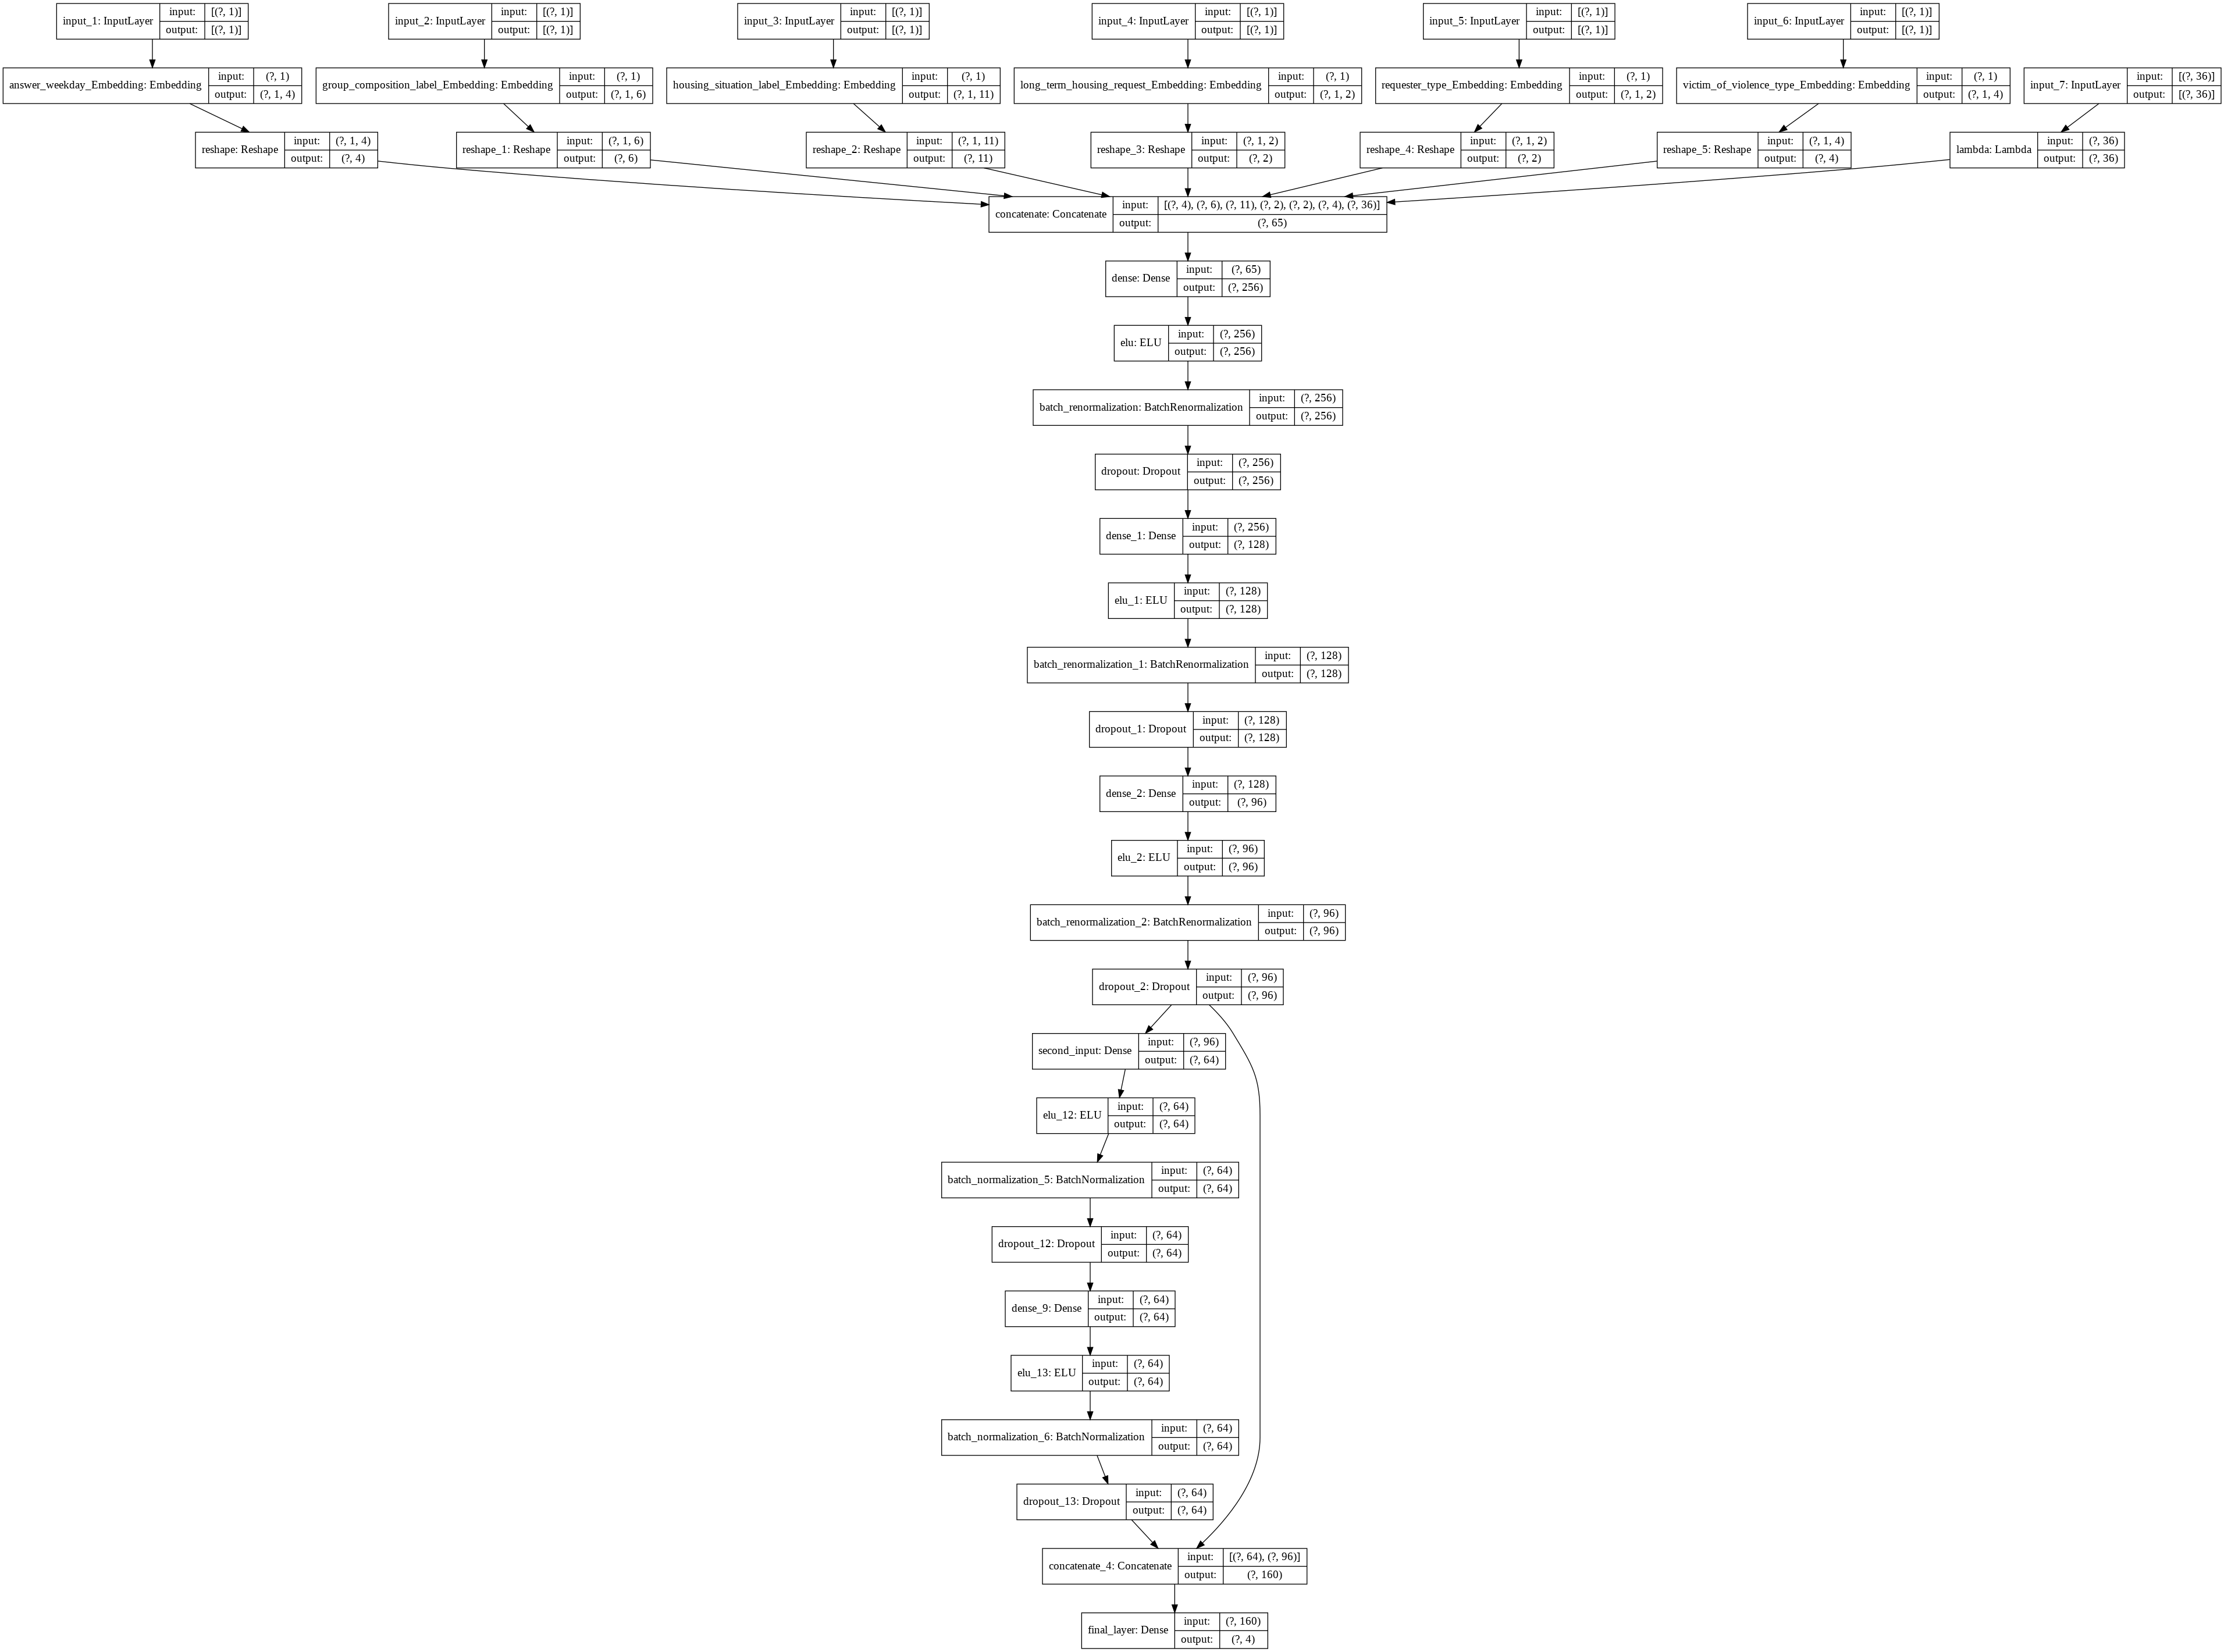

In [58]:

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')
